In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime
import math
import os 
print(f"PyTorch Version: {torch.__version__}")

PyTorch Version: 2.0.1+cu117


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
df_tr = pd.read_csv("train.csv")

In [4]:
missingIndex = df_tr[df_tr["MISSING_DATA"]].index
df_tr.drop(missingIndex, inplace=True)
print(df_tr.shape)

(1710660, 9)


In [5]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

def startValX(polyline): 
    if (polyline == "[]"): 
        return 0
    res = polyline.split(",")
    res = res[0].replace('[', '')
    res = res.replace(']', '')
    res = float(res)
    return res

def startValY(polyline): 
    if (polyline == "[]"): 
        return 0
    res = polyline.split(",")
    res = res[1].replace('[', '')
    res = res.replace(']', '')
    res = float(res)
    return res

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)
# polylineItem = df_tr["POLYLINE"].apply(polyline_getItem)
df_tr["START_COORDX"] = df_tr["POLYLINE"].apply(startValX)
df_tr["START_COORDY"] = df_tr["POLYLINE"].apply(startValY)
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,START_COORDX,START_COORDY
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,-8.618643,41.141412
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,-8.639847,41.159826
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,-8.612964,41.140359
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,-8.574678,41.151951
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,-8.645994,41.180490


In [6]:
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday(), dt.minute

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK", "MIN"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [7]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,START_COORDX,START_COORDY,YR,MON,DAY,HR,WK,MIN
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,-8.618643,41.141412,2013,7,1,0,0,0
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,-8.639847,41.159826,2013,7,1,0,0,8
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,-8.612964,41.140359,2013,7,1,0,0,2
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,-8.574678,41.151951,2013,7,1,0,0,0
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,-8.645994,41.180490,2013,7,1,0,0,4


In [9]:
idMap = {}
for (i, id) in enumerate(np.unique(df_tr['TAXI_ID'])):
    idMap[id] = i

In [10]:
def applyMap(id):
    return idMap[id]
df_tr["TAXI_ID"] = df_tr["TAXI_ID"].apply(applyMap)

In [11]:
df_trimmed = df_tr.copy()

In [12]:
df_trimmed = df_trimmed.reset_index()

In [13]:
for colum in df_trimmed:
    unique_values = np.unique(df_trimmed[colum])
    nr_values = len(unique_values)
    print(colum)
    if nr_values < 10:
        print("The number of unique values for features {} : {} --- {}".format(colum, nr_values,unique_values))
    elif nr_values == 19505: 
        nr_values_startx = unique_values
    elif nr_values == 15386:
        nr_values_starty = unique_values
    else:
         print("The number of unique values for features {} : {}".format(colum, nr_values))

full_rangex = nr_values_startx[-1] - nr_values_startx[0]
range_valuesx = []
range_valuesy = []
for i in nr_values_startx:
    if (i <= -9):
        range_valuesx.append(1)
    elif (i > -9 and i <= -8.7):
        range_valuesx.append(2)
    elif (i > -8.7 and i <= -8.6):
        range_valuesx.append(3)
    elif (i > -8.6 and i <= -8.5):
        range_valuesx.append(4)
    elif (i > -8.5 and i <= -8):
        range_valuesx.append(5)
    else:
        range_valuesx.append(6)
for i in nr_values_starty:
    if (i <= 37):
        range_valuesy.append(1)
    elif (i > 37 and i <= 40):
        range_valuesy.append(2)
    elif (i > 40 and i <= 41.25):
        range_valuesy.append(3)
    elif (i > 41.25 and i <= 43):
        range_valuesy.append(4)
    elif (i > 43 and i <= 44):
        range_valuesy.append(5)
    else:
        range_valuesy.append(6)

index
The number of unique values for features index : 1710660
TRIP_ID
The number of unique values for features TRIP_ID : 1710579
CALL_TYPE
The number of unique values for features CALL_TYPE : 3 --- ['A' 'B' 'C']
ORIGIN_CALL
The number of unique values for features ORIGIN_CALL : 57106
ORIGIN_STAND
The number of unique values for features ORIGIN_STAND : 64
TAXI_ID
The number of unique values for features TAXI_ID : 448
TIMESTAMP
The number of unique values for features TIMESTAMP : 1655357
DAY_TYPE
The number of unique values for features DAY_TYPE : 1 --- ['A']
MISSING_DATA
The number of unique values for features MISSING_DATA : 1 --- [False]
POLYLINE
The number of unique values for features POLYLINE : 1703640
LEN
The number of unique values for features LEN : 1254
START_COORDX
START_COORDY
YR
The number of unique values for features YR : 2 --- [2013 2014]
MON
The number of unique values for features MON : 12
DAY
The number of unique values for features DAY : 31
HR
The number of unique va

In [14]:
unique_values = np.unique(df_trimmed["MIN"])
def rangeMin(polyline):
    if (polyline < 5):
        return 1
    elif (polyline >= 5 and polyline < 10):
        return 2
    elif (polyline >= 10 and polyline < 15):
        return 3
    elif (polyline >= 15 and polyline < 20):
        return 4
    elif (polyline >= 20 and polyline < 25):
        return 5
    elif (polyline >= 25 and polyline < 30):
        return 6
    elif (polyline >= 30 and polyline < 35):
        return 7
    elif (polyline >= 35 and polyline < 40):
        return 8
    elif (polyline >= 40 and polyline < 45):
        return 9
    elif (polyline >= 45 and polyline < 50):
        return 10
    elif (polyline >= 50 and polyline < 55):
        return 11
    else:
        return 12
df_trimmed["MIN_RANGE"] = df_trimmed["MIN"].apply(rangeMin)
df_trimmed.tail()

,index,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,START_COORDX,START_COORDY,YR,MON,DAY,HR,WK,MIN,MIN_RANGE
1710655,1710665,1404171463620000698,C,NaN,NaN,434,1404171463,A,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",465,-8.612469,41.146020,2014,6,30,23,0,37,8
1710656,1710666,1404171367620000670,C,NaN,NaN,415,1404171367,A,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[...",435,-8.610138,41.140845,2014,6,30,23,0,36,8
1710657,1710667,1388745716620000264,C,NaN,NaN,173,1388745716,A,False,[],0,0.000000,0.000000,2014,1,3,10,4,41,9
1710658,1710668,1404141826620000248,B,NaN,12.0,160,1404141826,A,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-...",915,-8.630712,41.154885,2014,6,30,15,0,23,5
1710659,1710669,1404157147620000079,B,NaN,34.0,59,1404157147,A,False,"[[-8.615538,41.140629],[-8.615421,41.140746],[...",390,-8.615538,41.140629,2014,6,30,19,0,39,8


In [15]:
originStandList = []
def originStandRange(polyline):
    if (math.isnan(polyline) == False):
        originStandList.append(polyline)
    
df_trimmed["ORIGIN_CALL"].apply(originStandRange)
print(len(originStandList))

364769


In [16]:
def transform(data, num_category):
    one_hot = np.zeros(num_category, dtype=np.float16)
    one_hot[data] = 1
    return one_hot

def transform12Min(data):
    return transform(int(data-1), 12)

def transform24(data):
    return transform(data, 24)

def transform12(data):
    return transform(data, 13)[1:13]

def transform7(data):
    return transform(data, 7)

def transform31(data):
    return transform(data, 32)[1:32]

def transform448(data):
    return transform(data, 448)

def transformCallType(data):
    if data == 'A':
        return (1,0,0)
    elif data == 'B':
        return (0,1,0)
    else :
        return (0,0,1)

def parseOriginCall(data):
    if data != data:
        res = 0
    else:
        res = 1
    return res

def parseOriginStand(data):
    if math.isnan(data) == True:
        return np.zeros(63, dtype=np.float16)
    else:
        return transform(int(data-1), 63)
    return res

def parseStartX(data):
    return transform(data-1, 6)

def parseStartY(data):
    return transform(data-1, 6)

In [17]:
def getFeatureVectors(dataframe):
    one_hot_hours = dataframe["HR"].apply(transform24)
    one_hot_month = dataframe["MON"].apply(transform12)
    call_type = dataframe["CALL_TYPE"].apply(transformCallType)
    one_hot_min = dataframe["MIN_RANGE"].apply(transform12Min)
    taxi_id = dataframe["TAXI_ID"].apply(transform448)
    one_hot_dow = dataframe["WK"].apply(transform7)
#    one_hot_day = dataframe["DAY"].apply(transform31)
    o_call = dataframe["ORIGIN_CALL"].apply(parseOriginCall)
    o_stand = dataframe["ORIGIN_STAND"].apply(parseOriginStand)
#    startX = dataframe["STARTX"].apply(parseStartX)
#    startY = dataframe["STARTY"].apply(parseStartY)
    
    hours = torch.tensor(one_hot_hours, dtype=torch.float32)
    month = torch.tensor(one_hot_month, dtype=torch.float32)
    calls = torch.tensor(call_type, dtype=torch.float32)
    minutes = torch.tensor(one_hot_min, dtype=torch.float32)
    dayofweek = torch.tensor(one_hot_dow, dtype = torch.float32)
#    day = torch.tensor(one_hot_day, dtype = torch.float32)
    o_call = torch.tensor(o_call, dtype = torch.float32).reshape(-1,1)
    o_stand = torch.tensor(o_stand, dtype = torch.float32)
    taxi_id = torch.tensor(taxi_id, dtype = torch.float32)
#    startX = torch.tensor(startX, dtype = torch.float32)
#    startY = torch.tensor(startY, dtype = torch.float32)
    
    fv = torch.cat((hours, minutes), dim=1)
    fv = torch.cat((fv, month), dim=1)
    fv = torch.cat((fv, dayofweek), dim=1)
#    fv = torch.cat((fv, day), dim=1)
    fv = torch.cat((fv, calls), dim=1)
    fv = torch.cat((fv, o_call), dim=1)
    fv = torch.cat((fv, o_stand), dim=1)
    fv = torch.cat((fv, taxi_id), dim=1)
#    fv = torch.cat((fv, startX), dim=1)
#    fv = torch.cat((fv, startY), dim=1)
    return fv

In [18]:
raw_X = getFeatureVectors(df_trimmed)

/tmp/ipykernel_113/3461699243.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  hours = torch.tensor(one_hot_hours, dtype=torch.float32)


In [19]:
#the y values will be the actual trip times
raw_y = torch.tensor(df_trimmed["LEN"].values, dtype=torch.float32)

In [20]:
print(f"{raw_X.shape=} {raw_X.size()=}") 
print(f"{raw_y.shape=} {raw_y.size()=}") 

raw_X.shape=torch.Size([1710660, 570]) raw_X.size()=torch.Size([1710660, 570])
raw_y.shape=torch.Size([1710660]) raw_y.size()=torch.Size([1710660])


In [21]:
#randomly populate the training and testing set with 1.5 million in the training and the rest in the testing
def sampleData(raw_X, raw_Y, length, numSample):
    perm = torch.randperm(length)
    train_idx, test_idx = perm[:int(numSample * 0.9)], perm[int(numSample * 0.9):numSample]
    X_tr, Y_tr = raw_X[train_idx], raw_Y[train_idx]
    X_te, Y_te = raw_X[test_idx], raw_Y[test_idx]
    return X_tr, Y_tr, X_te, Y_te

In [22]:
X_tr, Y_tr, X_te, Y_te = sampleData(raw_X, raw_y, len(df_trimmed), len(df_trimmed))

In [23]:
print(f"{X_tr.shape=} {X_te.shape=}") 
print(f"{Y_tr.shape=} {Y_te.size()=}") 

X_tr.shape=torch.Size([1539594, 570]) X_te.shape=torch.Size([171066, 570])
Y_tr.shape=torch.Size([1539594]) Y_te.size()=torch.Size([171066])


In [24]:
#do any reshapings that has to be done
X_train, X_test = X_tr.reshape((-1, 570)), X_te.reshape((-1, 570))
y_train, y_test = Y_tr.reshape((-1, 1)), Y_te.reshape((-1, 1))

In [25]:
print(f"{X_train.shape=} {X_test.shape=}") 
print(f"{y_train.shape=} {y_test.size()=}") 

X_train.shape=torch.Size([1539594, 570]) X_test.shape=torch.Size([171066, 570])
y_train.shape=torch.Size([1539594, 1]) y_test.size()=torch.Size([171066, 1])


In [66]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(570, 700)
        self.dropout1 = nn.Dropout(p=0.7)
        self.fc2 = nn.Linear(700, 300)
        self.fc3 = nn.Linear(300, 1)

    def forward(self, x):
#         x = self.fc1(x).reshape(1,43)
# #         x = F.normalize(x).reshape(-1)
#         print(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net().to(device)

loss_fn = nn.MSELoss()

lr = 0.00001
opt = optim.SGD(model.parameters(), lr=lr)

In [67]:
train_err = []
test_err = []
parameters = []
high_loss_samples = []
epoch = 20
batch_size = 5000
for i_epoch in range(epoch):
    permutation = torch.randperm(X_train.size()[0])
    running_loss = 0
    n = 0
    for i in range(0,X_train.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices].to(device), y_train[indices].to(device)
        outputs = model(batch_x)
        loss = loss_fn(outputs,batch_y)
        if (i_epoch == 9):
            high_loss_samples.append(loss.item())
        running_loss += loss.item()
        n+=1
        opt.zero_grad() 
        loss.backward()
        opt.step()
    
    loss_rate = math.sqrt(running_loss / n)
    train_err.append(loss_rate)
    model.eval()
    with torch.no_grad():
        test_loss = math.sqrt(loss_fn(model(X_test.to(device)), y_test.to(device)).item())
        test_err.append(test_loss)
    print("Epoch: {0} \t Training Loss: {1:.8f} \t Test Loss: {2:.8f}".format(i_epoch+1, loss_rate, test_loss))


Epoch: 1 	 Training Loss: 815.95427234 	 Test Loss: 656.87303758
Epoch: 2 	 Training Loss: 675.62026373 	 Test Loss: 653.16553702
Epoch: 3 	 Training Loss: 672.43755104 	 Test Loss: 650.39271790
Epoch: 4 	 Training Loss: 669.52290749 	 Test Loss: 647.68807597
Epoch: 5 	 Training Loss: 666.83045215 	 Test Loss: 645.55743838
Epoch: 6 	 Training Loss: 663.85846384 	 Test Loss: 642.58250929
Epoch: 7 	 Training Loss: 661.10780922 	 Test Loss: 640.36515462
Epoch: 8 	 Training Loss: 658.86759486 	 Test Loss: 639.49948690
Epoch: 9 	 Training Loss: 656.98733945 	 Test Loss: 637.79324138
Epoch: 10 	 Training Loss: 655.48700845 	 Test Loss: 636.42072857
Epoch: 11 	 Training Loss: 654.21388581 	 Test Loss: 635.56259527
Epoch: 12 	 Training Loss: 653.19078709 	 Test Loss: 636.00847577
Epoch: 13 	 Training Loss: 652.30398464 	 Test Loss: 634.79142736
Epoch: 14 	 Training Loss: 651.52687190 	 Test Loss: 633.91610249
Epoch: 15 	 Training Loss: 650.98901515 	 Test Loss: 633.59354578
Epoch: 16 	 Trainin

In [28]:
print(df_trimmed["POLYLINE"][1])

[[-8.639847,41.159826],[-8.640351,41.159871],[-8.642196,41.160114],[-8.644455,41.160492],[-8.646921,41.160951],[-8.649999,41.161491],[-8.653167,41.162031],[-8.656434,41.16258],[-8.660178,41.163192],[-8.663112,41.163687],[-8.666235,41.1642],[-8.669169,41.164704],[-8.670852,41.165136],[-8.670942,41.166576],[-8.66961,41.167962],[-8.668098,41.168988],[-8.66664,41.170005],[-8.665767,41.170635],[-8.66574,41.170671]]


In [46]:
import heapq, random
print(len(high_loss_samples))

list_loss = []
trip_id_list = []
perm = torch.randperm(X_train.size()[0])

for i in range(0, X_train.size()[0], 1000):
    with torch.no_grad():
        index = perm[i]
        inputs = X_train[index].to(device)
        targets = y_train[index].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        list_loss.append((loss.item(),i))

def gen(n):
    yield from list_loss
    
res = heapq.nlargest(10, gen(len(list_loss)))
print(res)
for i in res:
    trip_id_list.append(df_trimmed["TRIP_ID"][i[1]])

print(res)
print(trip_id_list)

20
[(62825260.0, 1444000), (44279876.0, 1381000), (37079716.0, 319000), (21978776.0, 313000), (20723962.0, 1452000), (20169134.0, 1377000), (13660533.0, 820000), (13387992.0, 1252000), (11729190.0, 932000), (11266672.0, 705000)]
[(62825260.0, 1444000), (44279876.0, 1381000), (37079716.0, 319000), (21978776.0, 313000), (20723962.0, 1452000), (20169134.0, 1377000), (13660533.0, 820000), (13387992.0, 1252000), (11729190.0, 932000), (11266672.0, 705000)]
[1399627461620000383, 1398627880620000325, 1378924701620000199, 1378818550620000216, 1399731281620000450, 1398553985620000252, 1387766567620000503, 1396173409620000195, 1389994579620000224, 1385727469620000347]


[735, 750, 90, 465, 555, 465, 555, 225, 690, 390]


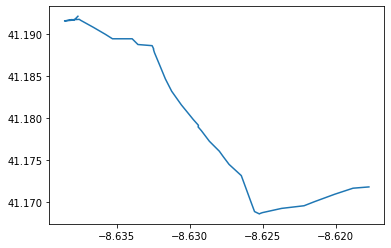

In [47]:
polyline_data = []
polyline_data_truth = []
for i in res:
    polyline_data.append(df_trimmed["POLYLINE"][i[1]])
    
for i in res:
    polyline_data_truth.append(df_trimmed["LEN"][i[1]])

print(polyline_data_truth)
plt_res = polyline_data[0]
res = plt_res.split(',')

plot_data = []
for j in range(0, len(res) - 1):
    res_el = res[j].replace('[', '')
    res_el = res_el.replace(']', '')
    res_el = res_el.replace(',', '')
    plot_data.append(float(res_el))
        
xpoints = []
ypoints = []
for k in range(0, len(plot_data) - 1):
    if (k % 2 == 0):
        xpoints.append(plot_data[k])
    if (k % 2 == 1):
        ypoints.append(plot_data[k])
            
plt.plot(xpoints, ypoints)
plt.show()
# ypoints = []
# for i in plt_res:
#    print(i)
#    xpoints.append(i[0])
#    ypoints.append(i[1])

# print(xpoints)
# print(ypoints)
# plt.plot(xpoints, ypoints)
# plt.show()

[-8.585577, -8.585577, -8.585577, -8.585649, -8.586459, -8.587242, -8.588358, -8.589672, -8.591787, -8.593848, -8.595954, -8.598033, -8.599617, -8.601246, -8.603001, -8.603829, -8.603847, -8.60517, -8.606358, -8.608608, -8.609535, -8.609634, -8.609634, -8.60967, -8.60994, -8.609967, -8.610003, -8.610021, -8.610021, -8.610021, -8.610012, -8.610048, -8.610093, -8.610075, -8.610867, -8.611236, -8.611254, -8.611443, -8.611524, -8.611587, -8.610984, -8.610894, -8.610552, -8.609661, -8.607906, -8.605863, -8.60526, -8.604873, -8.603199, -8.602011, -8.601642, -8.601219, -8.601327, -8.602308, -8.60391, -8.605035, -8.606853, -8.607789, -8.607798, -8.608356, -8.607951, -8.607879, -8.607564, -8.607141, -8.606727, -8.606493, -8.606511, -8.606502, -8.606466, -8.606079, -8.605683, -8.606277, -8.607843, -8.609184, -8.610687, -8.610327, -8.609319, -8.610696, -8.610975, -8.611884, -8.612217, -8.613207, -8.613774, -8.613576, -8.612739, -8.612892, -8.612991, -8.613009, -8.613009]
[41.176377, 41.176377, 41

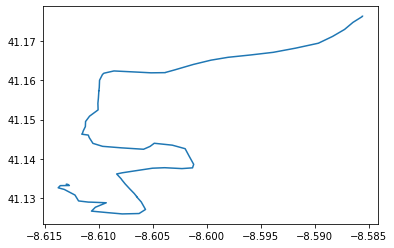

In [98]:
xpoints = []
ypoints = []
for i in range(0, len(plot_data) - 1):
    if (i % 2 == 0):
        xpoints.append(plot_data[i])
    if (i % 2 == 1):
        ypoints.append(plot_data[i])

print(xpoints)
print(ypoints)
plt.plot(xpoints, ypoints)
plt.show()

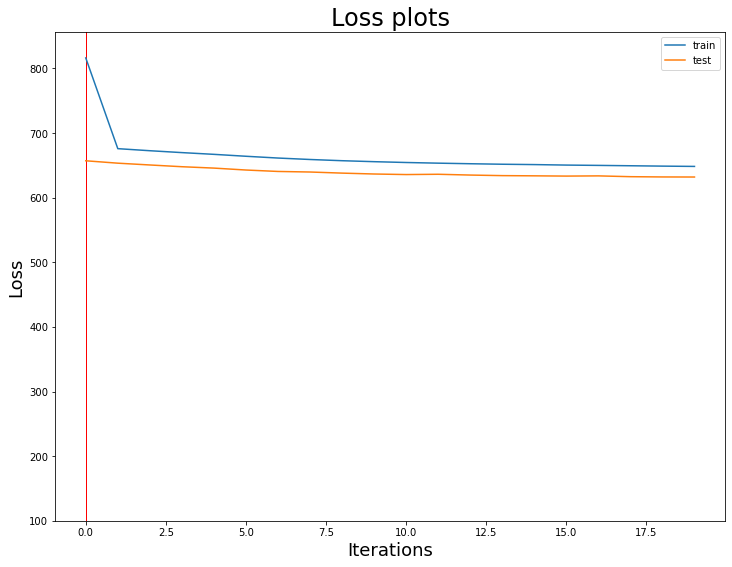

In [68]:
# print(train_err[epoch - 1 ])
# print(test_err[epoch - 1])

def visualize_graphs(train_err, test_err, title=""):
  plt.figure(figsize=(12,9))
  plt.axhline(color="red", lw=1)
  plt.axvline(color="red", lw=1)
  if title:
    plt.title(title, fontsize=24)
  plt.xlabel("Iterations", fontsize=18)
  plt.ylabel("Loss", fontsize=18)
  
  plt.plot(train_err, label="train")
  plt.plot(test_err, label="test")
  
  plt.ylim(100)
  
  plt.legend(loc="upper right")
  
  
visualize_graphs(train_err, test_err, "Loss plots")

In [69]:
predict = pd.read_csv("test_public.csv")

In [70]:
predict[["YR", "MON", "DAY", "HR", "WK", "MIN"]] = predict[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
predict.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,YR,MON,DAY,HR,WK,MIN
0,T1,B,NaN,15.0,20000542,1408039037,A,False,2014,8,14,17,3,57
1,T2,B,NaN,57.0,20000108,1408038611,A,False,2014,8,14,17,3,50
2,T3,B,NaN,15.0,20000370,1408038568,A,False,2014,8,14,17,3,49
3,T4,B,NaN,53.0,20000492,1408039090,A,False,2014,8,14,17,3,58
4,T5,B,NaN,18.0,20000621,1408039177,A,False,2014,8,14,17,3,59


In [71]:
predict["TAXI_ID"] = predict["TAXI_ID"].apply(applyMap)
predict["MIN_RANGE"] = predict["MIN"].apply(rangeMin)

In [72]:
predict_x = getFeatureVectors(predict)

In [73]:
model.eval()
with torch.no_grad():
    o = model(predict_x.to(device))
o = o.reshape(-1)
out = o.cpu().numpy()

In [74]:
out

array([ 782.47833,  664.1073 ,  747.3246 ,  623.92993,  708.261  ,
       1009.8409 ,  778.96954,  787.83185,  673.42053,  737.20386,
        636.75696,  708.98505,  637.3176 , 1214.1449 ,  792.26807,
        769.5324 ,  658.704  , 1004.23553,  800.4004 ,  783.3508 ,
        733.95306,  825.21783,  740.1233 ,  879.8395 ,  656.7331 ,
        732.0621 ,  813.77136,  794.07916,  716.4093 ,  825.54596,
        737.7073 ,  702.874  ,  653.41614,  802.1124 ,  906.23883,
        684.49866,  843.33026,  637.3494 ,  784.3588 ,  684.6124 ,
        646.19305,  570.1721 , 1184.8157 ,  708.1575 ,  646.46747,
        642.23474,  630.288  ,  655.61163,  639.97437,  640.57245,
        824.77136,  743.04315,  666.5232 ,  808.52295,  853.233  ,
        607.7098 ,  692.7197 ,  623.1482 , 1174.2812 ,  774.9428 ,
        797.2818 ,  654.48175,  577.23645,  837.57074,  659.5565 ,
        775.2309 ,  748.00507,  650.6447 ,  772.3786 ,  568.60236,
        823.999  ,  784.7559 ,  784.2917 ,  932.5716 ,  624.47

In [75]:
filePath = "./submissions/timestamp_id_pred_22.csv"

df_sample = pd.read_csv("sampleSubmission.csv")

for i in range(320):
    df_sample.at[i, "TRAVEL_TIME"] = float(out[i])

os.makedirs('./submissions/', exist_ok=True)
df_sample.to_csv(filePath, index=None, mode="+x")

In [81]:
os.makedirs('./saved_models/', exist_ok=True)
torch.save(model.state_dict(), './saved_models/163236.pth')

In [82]:
new_model = Net()